<a href="https://colab.research.google.com/github/JoeOlang/Drafts/blob/master/Vision/transfer_learning_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a short demo on image classification using CNN using data from Kaggle. 
For more info on the dataset see this [link.](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) <br>
Note: The Dataset may change over time.

In [12]:
# Getting Data From Kaggle


"""
import os
os.environ['KAGGLE_CONFIG_DIR'] = "path"    # Kaggle Json Auth File Path
%cd     # Change directory
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition     # API Download Command
!unzip \*.zip  && rm *.zip    #unzipping the zip files and deleting the zip files
"""

'\nimport os\nos.environ[\'KAGGLE_CONFIG_DIR\'] = "path"    # Kaggle Json Auth File Path\n%cd     # Change directory\n!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition     # API Download Command\n!unzip \\*.zip  && rm *.zip    #unzipping the zip files and deleting the zip files\n'

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import random
import gc

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Cats&Dogs/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Cats&Dogs/test'

train_dogs = ['/content/drive/MyDrive/Colab Notebooks/Computer Vision/Cats&Dogs/train/{}'.format(i) for i in os.listdir(train_dir) if 'dog' in i]
train_cats = ['/content/drive/MyDrive/Colab Notebooks/Computer Vision/Cats&Dogs/train/{}'.format(i) for i in os.listdir(train_dir) if 'cat' in i]

test_images = ['/content/drive/MyDrive/Colab Notebooks/Computer Vision/Cats&Dogs/test/{}'.format(i) for i in os.listdir(test_dir)]

train_imgs = train_dogs[:2000] + train_cats[:2000]
random.shuffle(train_imgs)

del train_dogs
del train_cats
gc.collect()

235

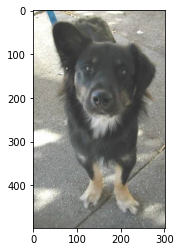

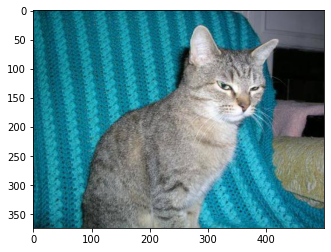

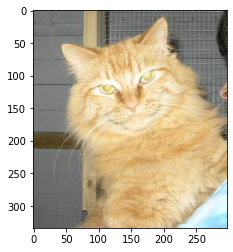

In [5]:
# View the first 3 images

for ima in train_imgs[0:3]:
    img = mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [6]:
# Resize images to 150 by 150 and use RGB (3) Colour Model, we be using a coloured image fam 🎃
nrows = 150
ncolumns = 150
channels = 3    # colour-RGB. channel, change to 1 for grayscale

In [7]:
# read - resize function
def process_img(list_of_imgs):

    X = []  #Rsized images
    y = []  #Labels

    for image in list_of_imgs:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))   #read image
        # get labels
        if 'dog' in image:
            y.append(1)
        elif 'cat' in image:
            y.append(0)

    return X, y

In [8]:
X, y = process_img(train_imgs)

In [9]:
y[:11]

[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]

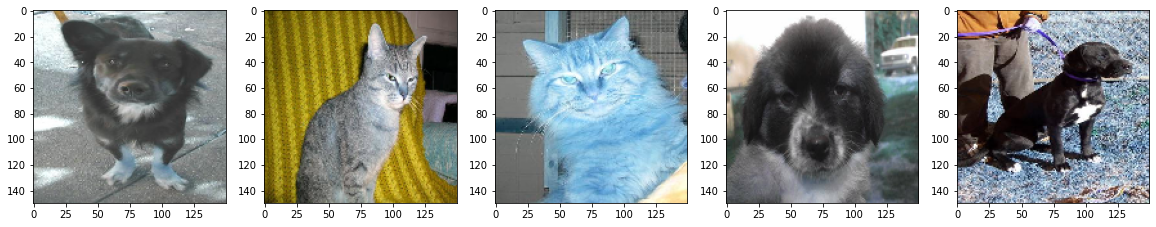

In [10]:
# Plot first 10 imgs to check if labels match
plt.figure(figsize=(20, 10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels')

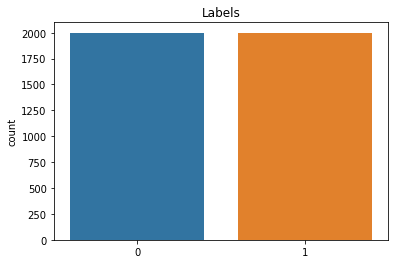

In [11]:
del train_imgs
gc.collect()

# Convert to NDarray
X = np.array(X)
y = np.array(y)

# Plot Labels
sns.countplot(y)
plt.title('Labels')

In [12]:
print('Train Shape', X.shape)   # batch size, height, width and channels
print('Label Shape', y.shape)

Train Shape (4000, 150, 150, 3)
Label Shape (4000,)


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print('Train Shape', X_val.shape)  
print('Label Shape', y_train.shape)

Train Shape (800, 150, 150, 3)
Label Shape (3200,)


In [14]:
# clear memory
del X
del y
gc.collect()


# get lenght of train and validation data
ntrain = len(X_train)
nval = len(X_val)

# we then use a batch size of 32. normaly this is a factor of 2 i.e. 2, 4, 8, 16, etc
batch_size = 32


Now we test out Transfer Learning. Rem Prev Acc was around 81%

In [15]:
from keras import models
from keras.applications import  InceptionResNetV2

conv_base = InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

219062272/219055592 [==============================] - 1s 0us/step


In [16]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [17]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


In [20]:
# Freeze our imported model, and only train the parts added
print('Number of weights before freezing conv base', len(model.trainable_weights))
conv_base.trainable = False
print('Number of weights after freezing conv base', len(model.trainable_weights))

Number of weights before freezing conv base 492
Number of weights after freezing conv base 4


In [21]:
# Compile our model, we use Binary Crossentropy since we have a two class problem at hand. For metrics we use acc i.e Accuracy to see how out model peforms.
# Changed learning rate from 0.0004 to 0.00002
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])  

In [22]:
# Augmentaion configuration, to help with reducing overfitting given the small dataset
train_datagen = ImageDataGenerator(rescale=1./255, # Scale the image between 0 and 1
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True,)

val_datagen = ImageDataGenerator(rescale=1./255)    # We dont augment validation data, we only peform rescale

In [23]:
# Create a train & validation data generator

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [24]:
# model training

history = model.fit_generator(train_generator,
                              steps_per_epoch = ntrain // batch_size,
                              epochs = 20,
                              validation_data = val_generator,
                              validation_steps = nval // batch_size)

Epoch 1/20
100/100 [==============================] - 64s 227ms/step - loss: 0.4860 - acc: 0.8248 - val_loss: 0.1289 - val_acc: 0.9450
Epoch 2/20
100/100 [==============================] - 20s 199ms/step - loss: 0.2094 - acc: 0.9155 - val_loss: 0.0954 - val_acc: 0.9563
Epoch 3/20
100/100 [==============================] - 20s 200ms/step - loss: 0.1865 - acc: 0.9202 - val_loss: 0.1193 - val_acc: 0.9538
Epoch 4/20
100/100 [==============================] - 20s 198ms/step - loss: 0.1858 - acc: 0.9238 - val_loss: 0.1176 - val_acc: 0.9563
Epoch 5/20
100/100 [==============================] - 20s 202ms/step - loss: 0.1663 - acc: 0.9289 - val_loss: 0.1381 - val_acc: 0.9475
Epoch 6/20
100/100 [==============================] - 20s 200ms/step - loss: 0.1704 - acc: 0.9291 - val_loss: 0.1536 - val_acc: 0.9450
Epoch 7/20
100/100 [==============================] - 20s 200ms/step - loss: 0.1569 - acc: 0.9399 - val_loss: 0.1115 - val_acc: 0.9550
Epoch 8/20
100/100 [==============================] - 2

In [25]:
# saving the model for later use

model.save_weights('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Cats&Dogs/tl_model_weights.h5')
model.save('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Cats&Dogs/tl_model_keras.h5')

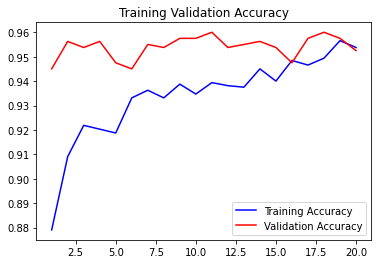

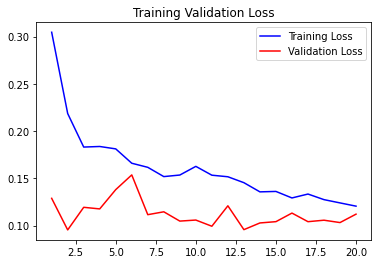

In [26]:
# Vissualize peformance over epochs

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training Validation Accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training Validation Loss')
plt.legend()

plt.show()

Import and Test the saved poctures in some new images

In [9]:
# load saved model i.e. model_keras

from tensorflow import keras    
model = keras.models.load_model('/Cats&Dogs/_model_keras.h5')

In [27]:
#test_dir = '/Cats&Dogs/test'
#test_images = ['/Cats&Dogs/test/{}'.format(i) for i in os.listdir(test_dir)]

X_test, y_test = process_img(test_images[0:10])     #Y_test will be empty since we dont have labels for these
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

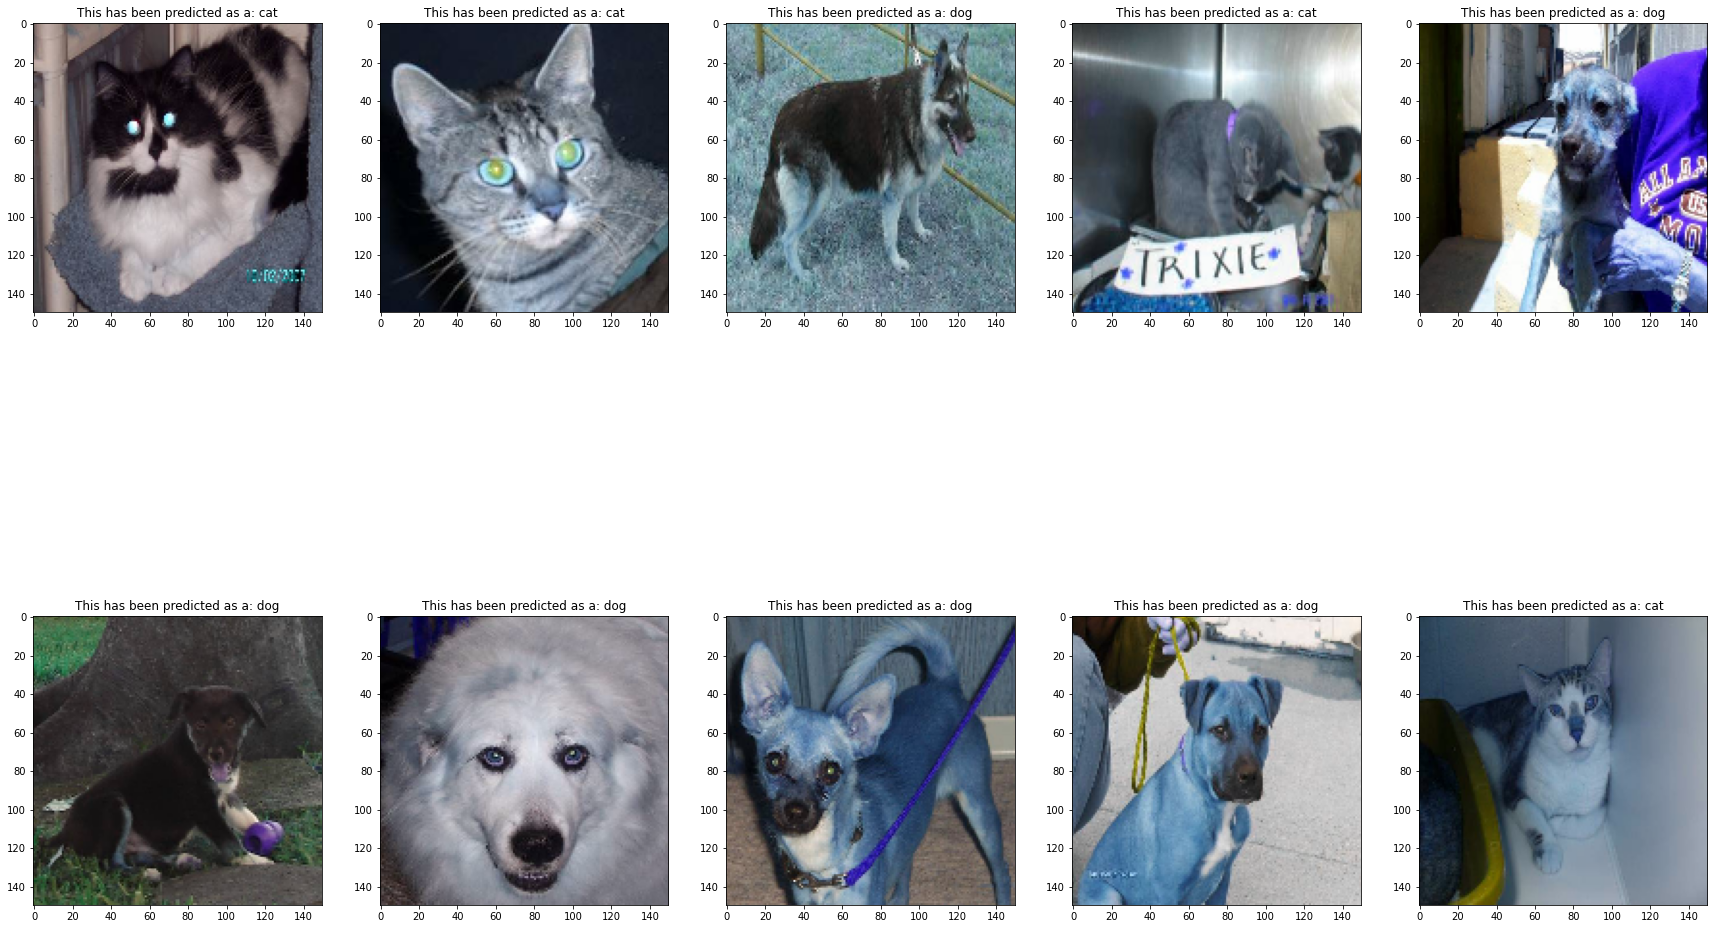

In [28]:
# Use a loop to go over the test cases and make predictions

i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This has been predicted as a: ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break

plt.show()

This is the end 😀